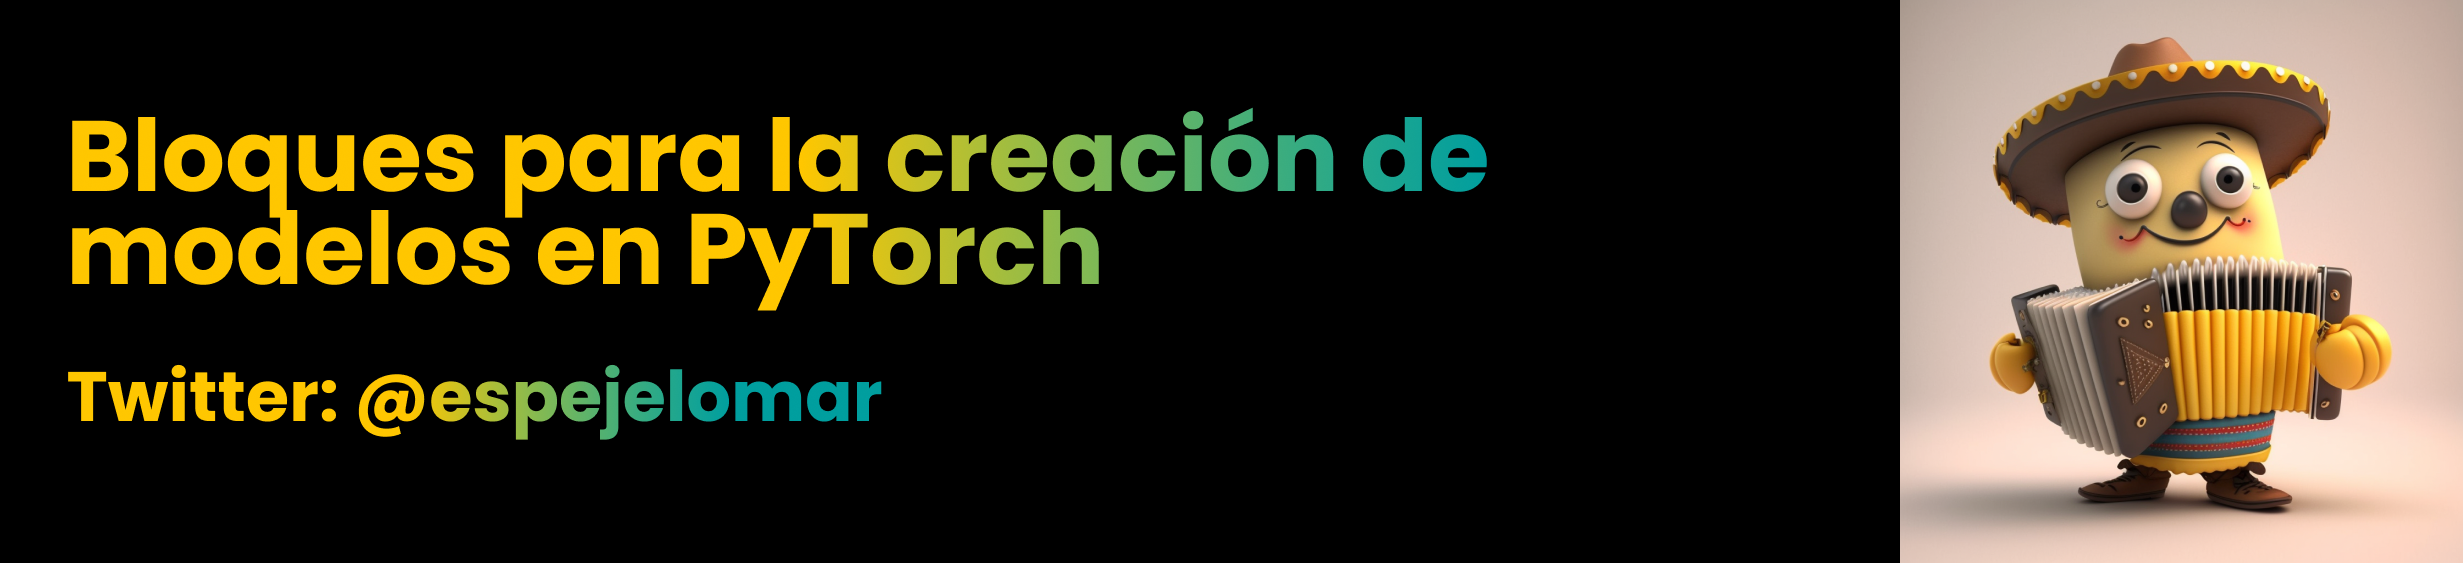

Cubriremos los fundamentos de la creación de un modelo PyTorch, desde la creación de un objeto `nn.Module` hasta el entrenamiento del modelo y la adición de una función de pérdida. 

Para empezar utilizaremos un ejemplo sencillo de regresión lineal para ilustrar estos conceptos. Al final de esta clase, tendrás una comprensión sólida de cómo funciona PyTorch y cómo crear y entrenar tus propios modelos. ¡Comencemos!

## Importar librerías

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Comprobar la versión de PyTorch
torch.__version__

'2.9.0+cu128'

# 1. Genera tus datos

Por agilidad, para este ejemplo, crearemos datos sintéticos. 

Creamos un tensor unidimensional llamado "X" que contiene un rango de valores, utilizando la función `arange`. Los parámetros de entrada "inicio", "final" y "step" especifican el inicio, final y tamaño del paso del rango respectivamente. 

La función `unsqueeze` se utiliza para agregar una dimensión adicional al tensor, lo que convierte el tensor unidimensional en un tensor de columna (con una dimensión adicional al final). 

En resumen, este código crea un tensor de columna con un rango de valores especificados.





In [2]:
# Crea *nuevos* parámetros
volumen = 0.8
sesgo = 0.2

# Crea datos
inicio = 0
final = 1
step = 0.025
X = torch.arange(inicio, final, step).unsqueeze(dim=1)
print(f"Shape de X: {X.shape}")
y = volumen * X + sesgo
print(f"Shape de y: {y.shape}")

X[:10], y[:10]

Shape de X: torch.Size([40, 1])
Shape de y: torch.Size([40, 1])


(tensor([[0.0000],
         [0.0250],
         [0.0500],
         [0.0750],
         [0.1000],
         [0.1250],
         [0.1500],
         [0.1750],
         [0.2000],
         [0.2250]]),
 tensor([[0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800]]))

Necesitamos un **conjunto de prueba** y uno de **entrenamiento**.

Cada conjunto tiene un objetivo específico:

*   **Conjunto de entrenamiento:** El modelo aprende de los datos.
*   **Conjunto de prueba:** El modelo se evalúa con los datos para probar lo que ha aprendido.




In [3]:
# Crea la división

train_division = int(0.7 * len(X)) # 70% de los datos utilizados para el conjunto de entrenamiento, 30% para pruebas
X_ent, y_ent = X[:train_division], y[:train_division]
X_prueb, y_prueb = X[train_division:], y[train_division:]


In [4]:
len(X_ent), len(X_prueb)

(28, 12)

Tenemos 28 muestras para entrenamiento (```X_ent``` y ```y_ent```) y 12 muestras de prueba (```X_prueb``` y ```y_prueb```) 


Visualizamos nuestros datos.


In [5]:
def plot_predictions(datos_ent=X_ent, 
                     etiq_ent=y_ent, 
                     datos_prueba=X_prueb, 
                     etiq_prueba=y_prueb, 
                     predictions=None):
  """
  Traza datos de entrenamiento, datos de prueba y compara predicciones
  """
  plt.figure(figsize=(10, 10))

  # Traza datos de entrenamiento en verde
  plt.scatter(datos_ent, etiq_ent, c="g", s=6, label="Datos de entrenamiento")
  
  # Traza datos de prueba en amarillo
  plt.scatter(datos_prueba, etiq_prueba, c="y", s=6, label="Datos de prueba")

  if predictions is not None:
    # Traza las predicciones en rojo
    plt.scatter(datos_prueba, predictions, c="r", s=6, label="Predicciones")

  # Leyenda
  plt.legend(prop={"size": 12});

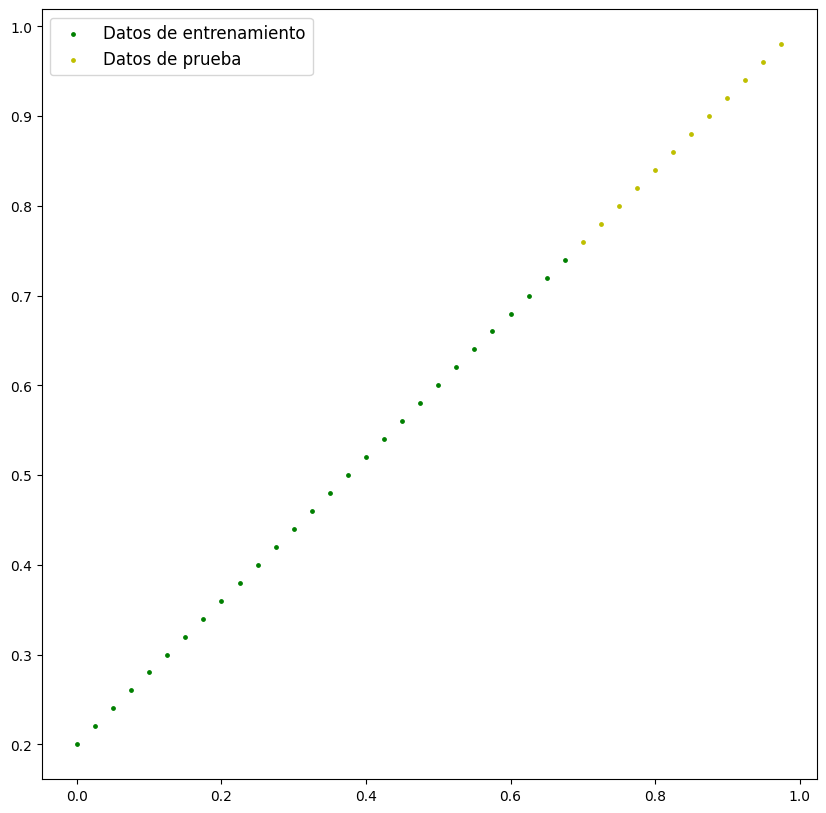

In [6]:
plot_predictions()

##### ¡Ya podemos visualizar nuestros datos en una línea recta!

# 2. Estructura de un modelo Pytorch


Construyamos un modelo de regresión lineal utilizando PyTorch.

`torch.nn` proporciona herramientas para construir redes neuronales, `torch.optim` para optimizar los modelos, `data.Dataset` para manejar los conjuntos de datos y `torch.utils.data.DataLoader` para cargar y transformar los datos. Estas herramientas son fundamentales para la construcción y entrenamiento de modelos de machine learning.

* `torch.nn`: es un módulo que proporciona clases y funciones para construir redes neuronales. Contiene una variedad de capas, como capas de convolución, capas de agrupación, capas de normalización, capas recurrentes y capas completamente conectadas, que se pueden combinar para construir una variedad de arquitecturas de redes neuronales.

* `torch.optim`: proporciona clases y funciones para optimizar los modelos de machine learning. Contiene una variedad de algoritmos de optimización, como SGD, Adam, Adagrad y Adadelta, que se utilizan para ajustar los parámetros de los modelos durante el entrenamiento.

* `torch.utils.data.Dataset`: es una clase que se utiliza para representar conjuntos de datos de machine learning. Proporciona una interfaz consistente para acceder a los datos y sus etiquetas. Se puede personalizar para trabajar con conjuntos de datos de diferentes formatos y tipos.

* `torch.utils.data.DataLoader`: es una clase que se utiliza para cargar y transformar datos de un conjunto en lotes para el entrenamiento de modelos. Se encarga de la asignación de los lotes, la mezcla de los datos y la carga de los datos en la GPU si es necesario, lo que facilita el procesamiento de grandes conjuntos de datos.

Por el momento, vamos a utilizar los dos primeros módulos. En el proyecto final usaremos `DataLoader`.

El siguiente fragmento define una clase llamada `ModeloRegresionLineal` que hereda de la clase `nn.Module` en PyTorch. 

La clase tiene dos parámetros ajustables (`volumen` y `sesgo`) que se inicializan con valores aleatorios y se pueden optimizar durante el entrenamiento. 

La función `forward` realiza el cálculo del modelo, donde se multiplica el tensor de entrada `x` por el parámetro `volumen` y se le agrega el parámetro `sesgo`.

En resumen, este código define una clase de modelo de regresión lineal con dos parámetros ajustables y define la operación de cálculo del modelo. Esto se utiliza como una plantilla para definir y entrenar modelos de regresión lineal en PyTorch.

In [7]:
# Crea una clase de modelo de regresión lineal
class ModeloRegresionLineal(nn.Module):
    def __init__(self):
        super().__init__()
        self.volumen = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)   # nn.Parameter para parámetros que pueden ser optimizados
        self.sesgo = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)     # nn.Parameter para parámetros que pueden ser optimizados
    


# Define el cálculo en el modelo
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.volumen * x + self.sesgo
    

`torch.manual_seed(42)` establece la semilla del generador de números aleatorios en 42. Lo que significa que los mismos números aleatorios se generarán en cada ejecución del código que utilice tensores de PyTorch. 

Esto puede ser útil para reproducir resultados y garantizar la reproducibilidad de los experimentos de machine learning.

In [8]:
torch.manual_seed(42)  # Fija la semilla para reproducibilidad

# Crea un objeto instanciando la clase ModeloRegresionLineal

model_1 = ModeloRegresionLineal()

`model_1.state_dict()` devolverá el diccionario que contiene los valores de todos los parámetros entrenables del modelo. Este diccionario puede ser útil para guardar y cargar modelos.

In [9]:
model_1.state_dict()

OrderedDict([('volumen', tensor([0.3367])), ('sesgo', tensor([0.1288]))])

Los valores de las variables `volumen` y `sesgo` aparecen como tensores aleatorios.

Iniciamos con parámetros aleatorios para luego hacer que el modelo los actualice hacia parámetros que se ajusten mejor a nuestros datos.


### Predicciones usando `torch.inference_mode()`

Para hacer predicciones con `torch.inference_mode()` podemos pasar los datos de prueba `X_prueb` para ver qué tan cerca pasan de `y_prueb`.

Cuando pasemos datos al modelo, pasarán por `forward()` produciendo un resultado con el cálculo que definimos anteriormente.

In [10]:
# Hacer predicciones con el modelo
with torch.inference_mode():
    y_predc = model_1(X_prueb)

> `#torch.inference_mode` se usa para hacer inferencia (predicciones). Además, desactiva algunas opciones como el seguimiento del gradiente (necesario para el entrenamiento, NO para inferencia).



In [11]:
# Comprueba las predicciones
y_predc


tensor([[0.3645],
        [0.3729],
        [0.3813],
        [0.3897],
        [0.3982],
        [0.4066],
        [0.4150],
        [0.4234],
        [0.4318],
        [0.4402],
        [0.4487],
        [0.4571]])

Hay un valor de predicción por muestra de prueba debido al tipo de datos implementados.



> En este caso, para una línea recta, un valor `X` se asigna a un valor `y`. Sin embargo, los modelos de aprendizaje automático son muy flexibles. Podemos asignar 80 valores de `X` para 10 valores `y`.

Visualicemos nuestros datos utilizando `plot_predictions()`



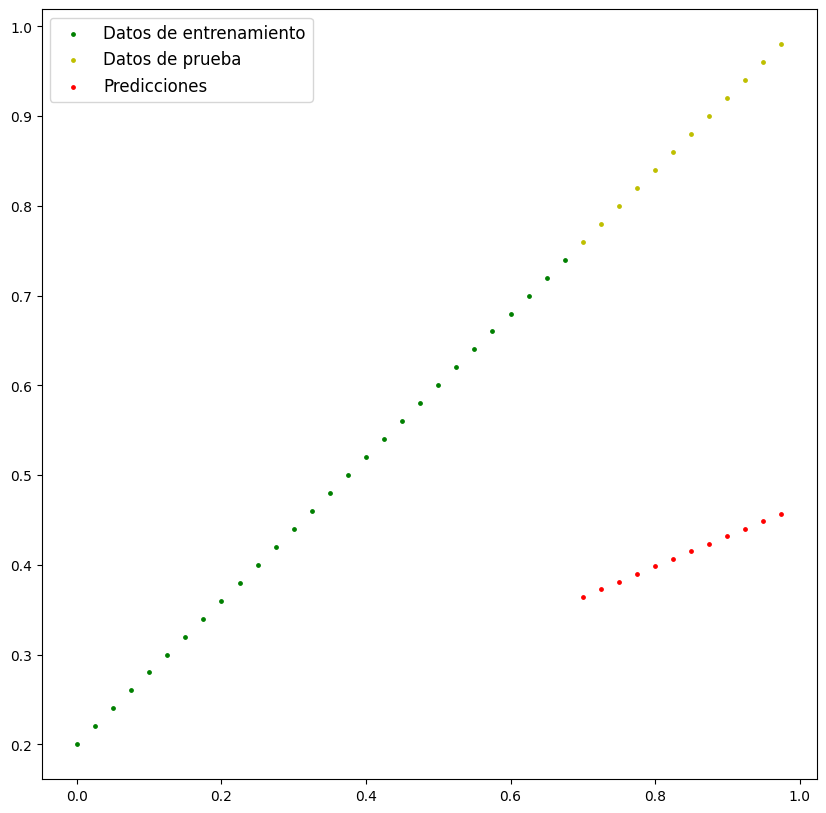

In [12]:
plot_predictions(predictions=y_predc)

Recuerda que nuestro modelo solo usa valores de parámetros aleatorios para hacer predicciones, básicamente al azar. **Por ello, la predicción se ve mal.**

# 3. Aplicación de función de pérdida y optimizadores en PyTorch

##### Para arreglar los valores aleatorios de los parámetros del modelo podemos actualizar los parámetros internos de las variables `# volumen` y `# sesgo` para representar mejor los datos.

Para ello, crearemos una **función de pérdida** así como un **optimizador** con PyTorch.

> La `# función de pérdida` mide qué tan equivocadas están las predicciones del modelo `# y_predc`, en comparación con las etiquetas `# y_prueb`. PyTorch tiene muchas funciones de pérdida integradas en `#torch.nn`.


> El `#optimizador` le indica a los modelos cómo actualizar sus parámetros internos para reducir la pérdida. Podemos encontrar varias implementaciones en `#torch.optim`.

Dependiendo del tipo de problema que estemos trabajando vamos a emplear una determinada función de pérdida y optimización.

Para nuestro problema utilizaremos el **Error Cuadrático Medio (MAE)** como la función de pérdida `(torch.nn.L1Loss)` para medir la diferencia absoluta entre dos puntos y tomar la media en todos los ejemplos.

También usaremos **Stochastic Gradient Descent (SGD)** `(torch.optim.SGD(params, lr))` como nuestro optimizador, donde `# params` son los parámetros del modelo (volumen y sesgo) y `# lr` es la tasa de aprendizaje a la que desea que el optimizador actualice los parámetros.

Además, fijamos arbitrariamente una tasa de aprendizaje de 0.01


In [13]:
# Crea función de pérdida
fn_perd = torch.nn.L1Loss()  # L1Loss (también conocido como MAE - Mean Absolute Error)

# Crea el optimizador

optimizador = torch.optim.SGD(params=model_1.parameters(), lr=0.01)      # tasa de aprendizaje (cuánto debe cambiar el optimizador de parámetros en cada paso, más alto = más (menos estable), más bajo = menos (puede llevar mucho tiempo))

In [14]:
optimizador

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Ya que tenemos una función de pérdida y un optimizador, vamos a crear un ciclo de entrenamiento y uno de prueba. Esto implica que el modelo pase por los datos de entrenamiento y aprenda la relación entre `features` y `labels`.

El ciclo de prueba implica revisar los datos de prueba y evaluar qué tan buenos son los patrones que el modelo aprendió de los datos de entrenamiento.

Para entrenar, vamos a escribir un bucle `for` de Python.


### Bucle de entrenamiento:

**Pasos a seguir:**

1.  El modelo pasa por todos los datos de entrenamiento nuevamente, realizando sus cálculos en funciones `forward ()`. *Código:* `modelo(X_ent)`
2. Las predicciones se comparan  y se evalúan para ver qué tan equivocadas están. *Código:* `perdida = fn_perd(y_predc, y_ent)`.
3. Los gradientes de los optimizadores se establecen en cero para que puedan recalcularse y dar paso al entrenamiento específico. *Código:* `optimizer.zero_grad()`.
4. Se calcula la pérdida del gradiente con respecto a cada parámetro que se actualizará (retroprogramación). *Código:* `loss.backward()`.
5. Se actualizan los parámetros con `requires_grand=True` respecto a la pérdida para mejorarlos. *Código:* `optimizer.step()`.

In [15]:
torch.manual_seed(42)

# Establezca cuántas veces el modelo pasará por los datos de entrenamiento
epocas = 500

# Cree listas de vacías para realizar un seguimiento de nuestro modelo
entrenamiento_loss = []
test_loss = []

for epoca in range(epocas):
    ### Entrenamiento

    # Pon el modelo en modo entrenamiento
    model_1.train()

    # 1. Pase hacia adelante los datos usando el método forward() 
    y_predc = model_1(X_ent)

    # 2. Calcula la pérdida (Cuán diferentes son las predicciones de nuestros modelos)
    perdida = fn_perd(y_predc, y_ent)

    # 3. Gradiente cero del optomizador
    optimizador.zero_grad()

    # 4. Pérdida al revés
    perdida.backward()

    # 5. Progreso del optimizador
    optimizador.step()

    ### Función de prueba

    # Pon el modelo en modo evaluación
    model_1.eval()

    with torch.inference_mode():
      # 1. Reenviar datos de prueba
      prueba_predc = model_1(X_prueb)

      # 2. Calcular la pérdida en datos de prueba
      prueb_perd = fn_perd(prueba_predc, y_prueb.type(torch.float32))

      # Imprime lo que está pasando
      if epoca % 10 == 0:
          entrenamiento_loss.append(perdida.detach().numpy())
          test_loss.append(prueb_perd.detach().numpy())
          print(f"Época: {epoca:3} | Pérdida de entrenamiento: {perdida:.5f} | Pérdida de test: {prueb_perd:.5f}")
    

Época:   0 | Pérdida de entrenamiento: 0.22756 | Pérdida de test: 0.44639
Época:  10 | Pérdida de entrenamiento: 0.12173 | Pérdida de test: 0.32247
Época:  20 | Pérdida de entrenamiento: 0.07874 | Pérdida de test: 0.24352
Época:  30 | Pérdida de entrenamiento: 0.06663 | Pérdida de test: 0.20124
Época:  40 | Pérdida de entrenamiento: 0.06197 | Pérdida de test: 0.17842
Época:  50 | Pérdida de entrenamiento: 0.05890 | Pérdida de test: 0.16377
Época:  60 | Pérdida de entrenamiento: 0.05612 | Pérdida de test: 0.15558
Época:  70 | Pérdida de entrenamiento: 0.05339 | Pérdida de test: 0.14739
Época:  80 | Pérdida de entrenamiento: 0.05066 | Pérdida de test: 0.14012
Época:  90 | Pérdida de entrenamiento: 0.04793 | Pérdida de test: 0.13285
Época: 100 | Pérdida de entrenamiento: 0.04521 | Pérdida de test: 0.12466
Época: 110 | Pérdida de entrenamiento: 0.04248 | Pérdida de test: 0.11739
Época: 120 | Pérdida de entrenamiento: 0.03974 | Pérdida de test: 0.11013
Época: 130 | Pérdida de entrenamiento:

##### Parece que nuestra pérdida fue disminuyendo con cada época, veamos graficamente:

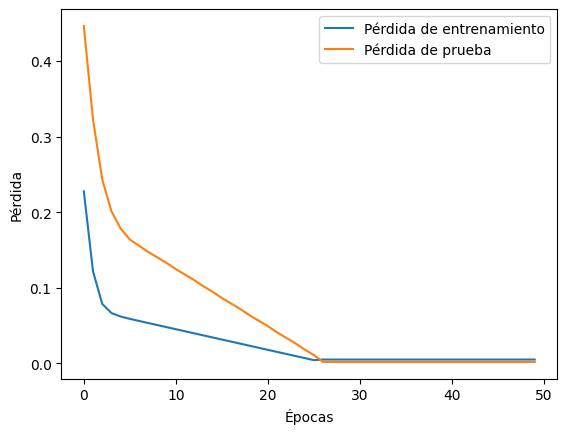

In [16]:
# Traza las curvas de pérdida
plt.plot(entrenamiento_loss, label="Pérdida de entrenamiento")
plt.plot(test_loss, label="Pérdida de prueba")
plt.ylabel("Pérdida")
plt.xlabel("Épocas")
plt.legend()
plt.show()

# 4. Inferencia con un modelo PyTorch entrenado

##### Una vez entrenado el modelo, podemos hacer inferencia (predicciones) con él.

Hay tres aspectos que debemos recordar para hacer predicciones correctamente:

1. Configurar el modelo en modo de evaluación `(model.eval())`.
2. Realizar las predicciones utilizando el administrador de contexto del modo de inferencia `(with torch.inference_mode(): ...)`.
3. Todas las predicciones deben realizarse con objetos en el mismo dispositivo (datos y modelo solo en GPU o datos y modelo solo en CPU).


In [19]:
# 1. Configure el modelo en modo de evaluación
model_1.eval()

# 2. Configure el administrador de contexto del modo de inferencia
with torch.inference_mode():

# 3. Asegúrese de que los cálculos se realicen con el modelo y los datos en el mismo dispositivo en nuestro caso, nuestros datos y modelo están en la CPU de forma predeterminada
  # model_1.to(device)
  # X_prueb = X_prueb.to(device)
  y_predc = model_1(X_prueb)

In [20]:
y_predc

tensor([[0.7507],
        [0.7704],
        [0.7901],
        [0.8098],
        [0.8295],
        [0.8493],
        [0.8690],
        [0.8887],
        [0.9084],
        [0.9281],
        [0.9478],
        [0.9675]])

Observa cómo se ve gráficamente el modelo entrenado:


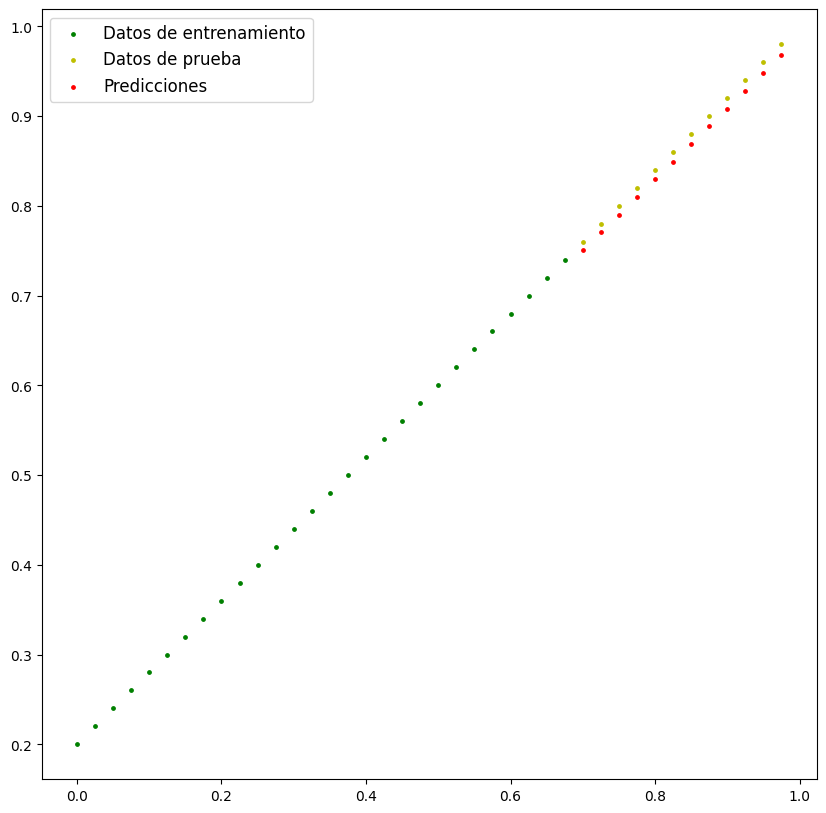

In [21]:
plot_predictions(predictions = y_predc)

#### Gráficamente, los puntos rojos se ven mucho más cerca de lo que estaban antes.



## Conclusión

En estas clases, aprendimos los conceptos básicos para crear un modelo PyTorch para regresión lineal. Comenzamos utilizando el módulo *`nn`* para definir la arquitectura de nuestro modelo. Luego configuramos un optimizador y una función de pérdida. A continuación, entrenamos y evaluamos nuestro modelo utilizando un pequeño conjunto de datos.

Para las próximas clases continuaremos construyendo sobre esta base para crear modelos más complejos, comenzando con redes neuronales. Profundizaremos en PyTorch y exploraremos técnicas más avanzadas para crear y entrenar modelos. 

¡Prepárate para aprender y experimentar mientras continuamos nuestro viaje a través de PyTorch!